# Arabic Letters Classification

In this notebook we will implement a high quality (95% accuracy) arabic letter classifier using CNN with ResNet 34 Architecture and the following dataset available on kaggle.

We will use **FastAI** library, it's built on top of pytorch and implements some of the best practice and techniques to train neural networks. 


## Saving the Dataset on Google drive

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
root_path = 'gdrive/My Drive/your_project_folder/' 
from google.colab import files
files.upload() #this will prompt you to update the json

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
kaggle.json


In [ ]:
!kaggle datasets download -d mloey1/ahcd1 -p /content/gdrive/My\ Drive/Kaggle/arabic

 96% 23.0M/24.0M [00:00<00:00, 22.0MB/s]
100% 24.0M/24.0M [00:00<00:00, 32.9MB/s]


In [ ]:
import os
os.chdir('gdrive/My Drive/Kaggle')  #change dir

!unzip arabic/ahcd1.zip -d arabic/



Streaming output truncated to the last 5000 lines.
  inflating: arabic/train images 13440x32x32/train/id_5501_label_16.png  
  inflating: arabic/train images 13440x32x32/train/id_5502_label_16.png  
  inflating: arabic/train images 13440x32x32/train/id_5503_label_16.png  
  inflating: arabic/train images 13440x32x32/train/id_5504_label_16.png  
  inflating: arabic/train images 13440x32x32/train/id_5505_label_17.png  
  inflating: arabic/train images 13440x32x32/train/id_5506_label_17.png  
  inflating: arabic/train images 13440x32x32/train/id_5507_label_17.png  
  inflating: arabic/train images 13440x32x32/train/id_5508_label_17.png  
  inflating: arabic/train images 13440x32x32/train/id_5509_label_17.png  
  inflating: arabic/train images 13440x32x32/train/id_550_label_13.png  
  inflating: arabic/train images 13440x32x32/train/id_5510_label_17.png  
  inflating: arabic/train images 13440x32x32/train/id_5511_label_17.png  
  inflating: arabic/train images 13440x32x32/train/id_5512_lab

## Exploring the data



We will explore the data, if you already have installed the datatset just start from here


In [ ]:
from fastai.vision import *
from fastai.metrics import error_rate
import pandas as pd
import os

os.chdir("gdrive/My Drive/Kaggle")


Creating labels: we will map each arabic letter to its number in the arabic alphabet, then we will create a dataframe with 2 columns: name for the image path, and it's label. 


In [ ]:
!ls
path = "arabic/train images 13440x32x32/train/"
path_list = ["train/" + fn for fn in  os.listdir(path)]
letters = ["ي","و","ه","ن","م","ل","ك","ق","ف","غ","ع","ظ","ط","ض","ص","ش","س","ز","ر","ذ","د","خ","ح","ج","ث","ت","ب","ا"]
letters.reverse()
labels_num = [path.split("_")[-1].strip(".png") for path in path_list]
print(labels_num)
print(letters[int('18')-1])
labels = [letters[int(i)-1] for i in labels_num]
print(labels)
path_df = pd.DataFrame()
path_df["name"] = path_list


path_df["label"] = labels

print(path_df.shape)


arabic	kaggle.json
['22', '17', '9', '17', '26', '14', '15', '4', '13', '4', '19', '4', '15', '7', '24', '22', '26', '3', '14', '2', '13', '28', '5', '3', '22', '8', '26', '4', '26', '2', '2', '27', '5', '20', '27', '16', '10', '4', '16', '14', '4', '22', '6', '4', '4', '12', '23', '27', '28', '23', '10', '10', '10', '16', '23', '24', '21', '4', '17', '22', '11', '27', '4', '10', '7', '27', '16', '17', '6', '23', '27', '21', '10', '3', '18', '5', '11', '19', '9', '15', '26', '16', '20', '12', '2', '18', '10', '18', '1', '19', '7', '9', '1', '4', '7', '2', '11', '12', '24', '20', '27', '4', '4', '28', '5', '2', '7', '20', '15', '13', '14', '7', '3', '7', '12', '15', '4', '2', '3', '25', '13', '25', '21', '8', '1', '24', '7', '21', '17', '7', '18', '25', '4', '13', '19', '28', '9', '8', '4', '2', '13', '11', '28', '8', '27', '21', '16', '20', '15', '25', '11', '14', '21', '5', '3', '16', '10', '11', '20', '2', '14', '15', '8', '26', '22', '9', '9', '9', '10', '8', '20', '13', '14', '5', 

We can now create the DataBunch (Fast AI API object) and normalize it using ImageNet stats (mean and std)


In [ ]:
# Create the data bunch


data = ImageDataBunch.from_df("arabic/train images 13440x32x32/",path_df,size=224,bs=64)
data = data.normalize(imagenet_stats)

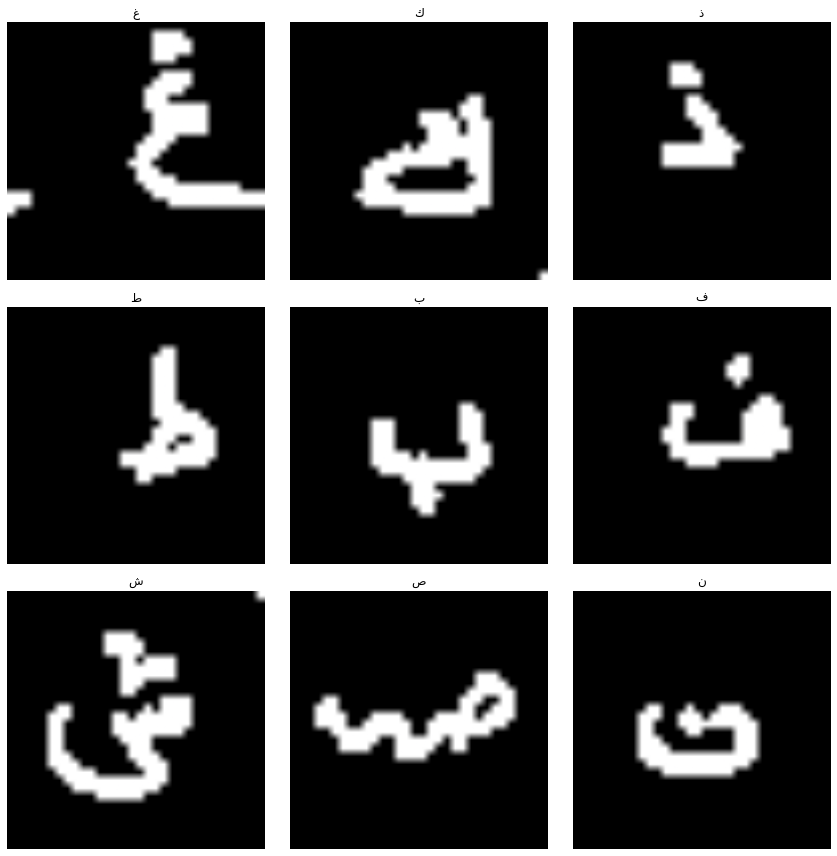

In [ ]:
data.show_batch(3)

## Training a RESNET 34


We will create a cnn learner object and give it the ResNet 34 architecture, this way we will use transfer learning, we don't have to all the weights, we can use the great ResNet results and pretrained weights in our model.


In [ ]:
learner = cnn_learner(data,models.resnet34,metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth


If you have trained the model and saved it, just load it, otherwise un comment the next block and train it using the 1 cycle policy and through 8 epochs we can get an accuracy of 90-91%

In [ ]:
learner.load("model-34")

Learner(data=ImageDataBunch;

Train: LabelList (10752 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
ك,ذ,ظ,ه,ص
Path: arabic/train images 13440x32x32;

Valid: LabelList (2688 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
ث,ن,ح,ش,ز
Path: arabic/train images 13440x32x32;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_r

In [ ]:
## If model doesn't exist (not saved) run training
#learner.fit_one_cycle(8)

epoch,train_loss,valid_loss,error_rate,time
0,1.836220,0.970257,0.302827,01:14
1,0.958899,0.656171,0.203125,01:15
2,0.656006,0.504711,0.162574,01:14
3,0.473130,0.420922,0.134673,01:13
4,0.334949,0.348618,0.106027,01:14
5,0.244006,0.318495,0.103795,01:14
6,0.185835,0.305995,0.093006,01:15
7,0.146555,0.302528,0.098214,01:15


In [ ]:
interp = ClassificationInterpretation.from_learner(learner)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

In [ ]:
learner.save("model-34",return_path=True)

PosixPath('arabic/train images 13440x32x32/models/model-34.pth')

## Improving the model

We will use Leslie's Smith cyclical learning rate and use fast ai learning rate finder to set good bounds.


In [ ]:
learner.lr_find()

epoch,train_loss,valid_loss,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


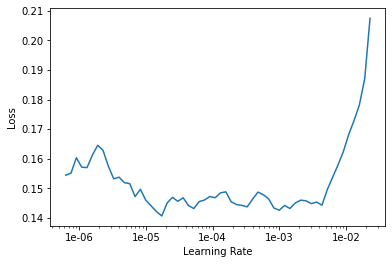

In [ ]:
learner.recorder.plot()

In [ ]:
learner.load("model-34")
learner.unfreeze()

In [ ]:
learner.fit_one_cycle(6,max_lr=slice(1e-5,1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.157589,0.293036,0.090402,01:24
1,0.176175,0.277629,0.083333,01:26
2,0.102786,0.216725,0.061756,01:25
3,0.059539,0.187320,0.057664,01:26
4,0.029634,0.173774,0.049479,01:25
5,0.020046,0.168368,0.049107,01:25


In [ ]:
learner.save("model-34-better")

In [ ]:
interp = ClassificationInterpretation.from_learner(learner)

losses,idxs = interp.top_losses()

Let's see the most confused classes.

In [ ]:
interp.most_confused()

[('ذ', 'د', 6),
 ('ذ', 'ز', 6),
 ('ت', 'ن', 5),
 ('ص', 'س', 5),
 ('ف', 'ق', 4),
 ('ج', 'ح', 3),
 ('ح', 'ج', 3),
 ('ز', 'ذ', 3),
 ('ز', 'ر', 3),
 ('ظ', 'ط', 3),
 ('غ', 'خ', 3),
 ('ن', 'ث', 3),
 ('ه', 'و', 3),
 ('ت', 'ث', 2),
 ('ث', 'ت', 2),
 ('ث', 'ف', 2),
 ('ج', 'ق', 2),
 ('ح', 'ع', 2),
 ('خ', 'ح', 2),
 ('خ', 'ع', 2),
 ('خ', 'غ', 2),
 ('د', 'ر', 2),
 ('ر', 'ز', 2),
 ('ش', 'ض', 2),
 ('ض', 'ص', 2),
 ('ع', 'ط', 2),
 ('ع', 'غ', 2),
 ('غ', 'ع', 2),
 ('ق', 'ف', 2),
 ('ك', 'ن', 2),
 ('ن', 'ك', 2),
 ('ا', 'م', 1),
 ('ب', 'ن', 1),
 ('ت', 'ص', 1),
 ('ت', 'ق', 1),
 ('ث', 'ض', 1),
 ('ج', 'ه', 1),
 ('د', 'و', 1),
 ('ذ', 'ط', 1),
 ('ذ', 'و', 1),
 ('ر', 'د', 1),
 ('س', 'ص', 1),
 ('س', 'ض', 1),
 ('ش', 'ث', 1),
 ('ش', 'س', 1),
 ('ش', 'ف', 1),
 ('ش', 'ل', 1),
 ('ص', 'م', 1),
 ('ص', 'ي', 1),
 ('ض', 'س', 1),
 ('ض', 'ش', 1),
 ('ض', 'ط', 1),
 ('ض', 'ف', 1),
 ('ط', 'ث', 1),
 ('ع', 'ج', 1),
 ('ع', 'خ', 1),
 ('ف', 'ت', 1),
 ('ف', 'ث', 1),
 ('ف', 'ل', 1),
 ('ف', 'ن', 1),
 ('ق', 'ت', 1),
 ('ق', 'ن', 1),
 ('ق', '

## Testing on an image

In [ ]:
"""
# DONT RUN THIS IF YOU ALREADY LOADED THE MODEL USING THE PKL FILE

learner.load("model-34-better")
# Exporting it to pkl to use for inference
learner.export()
"""

In [ ]:
from google.colab import files
files.upload()


Saving untitled (1).png to untitled (1).png


{'untitled (1).png': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x02\xab\x00\x00\x01\x80\x08\x06\x00\x00\x00\x8a\x98+\x99\x00\x00\x19\xb9IDATx^\xed\xdc\xd1v\xdbF\x12\x04P\xf1\xff?\x9a9vBGQh\x0bC\x02\x98B\xcd\xdd\xd7\x85\x80\xee[\x83\x83\x8aV\x9b\xdb\xfd~\xbf\x7f\xf8\x0f\x01\x02\x04\x08\x10 @\x80\x00\x81@\x81\x9b\xb2\x1a\x98\x8a\x91\x08\x10 @\x80\x00\x01\x02\x04~\n(\xab\x0e\x02\x01\x02\x04\x08\x10 @\x80@\xac\x80\xb2\x1a\x1b\x8d\xc1\x08\x10 @\x80\x00\x01\x02\x04\x94Ug\x80\x00\x01\x02\x04\x08\x10 @ V@Y\x8d\x8d\xc6`\x04\x08\x10 @\x80\x00\x01\x02\xca\xaa3@\x80\x00\x01\x02\x04\x08\x10 \x10+\xa0\xac\xc6Fc0\x02\x04\x08\x10 @\x80\x00\x01e\xd5\x19 @\x80\x00\x01\x02\x04\x08\x10\x88\x15PVc\xa31\x18\x01\x02\x04\x08\x10 @\x80\x80\xb2\xea\x0c\x10 @\x80\x00\x01\x02\x04\x08\xc4\n(\xab\xb1\xd1\x18\x8c\x00\x01\x02\x04\x08\x10 @@Yu\x06\x08\x10 @\x80\x00\x01\x02\x04b\x05\x94\xd5\xd8h\x0cF\x80\x00\x01\x02\x04\x08\x10 \xa0\xac:\x03\x04\x08\x10 @\x80\x00\x01\x02\xb1\x02\xcajl4\x06#@\x80\x00\x01\x02\x04\x08\

Let's load the learner for inference and then test it on image


In [ ]:
path = "arabic/test images 3360x32x32/train images 13440x32x32/"
learner_test = load_learner(path)

Now let's try on the image, the image have to follow the same rules the dataset was created upon (32*32, dark background...etc) surely with production we can just use opencv or other libraries to preprocess the images



Letter class: ق


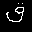

In [ ]:
img = open_image("/content/pic7.png")
result = learner_test.predict(img)[0]

print("Letter class:",result)
img

Letter class: ك


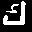

In [ ]:
img = open_image("/content/pic8.png")
result = learner_test.predict(img)[0]

print("Letter class:",result)
img